In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
import collections

In [2]:
# set seed
seed = 42
random.seed(seed)
np.random.seed(seed)

In [3]:
train_data=pd.read_csv("../data/train.csv")

In [4]:
test_data=pd.read_csv("../data/test.csv")

In [5]:
# Count missing values for each column
missing_values = train_data.isnull().sum()

# Create a DataFrame to store the count of missing values
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'MissingCount': missing_values.values
})

# Add a column to show the percentage of missing values
missing_df['MissingPercentage'] = (missing_df['MissingCount'] / len(train_data)) * 100

# Sort the DataFrame by the number of missing values in descending order
missing_df.sort_values(by='MissingCount', ascending=False, inplace=True)

# Reset index for readability
missing_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(missing_df)

                          Column  MissingCount  MissingPercentage
0             FarmClassification        112552          99.984898
1       PerimeterGuardPlantsArea        112525          99.960913
2         UndergroundStorageSqft        112512          99.949364
3                 FieldZoneLevel        112512          99.949364
4             HarvestStorageSqft        112457          99.900505
5                  HasGreenHouse        112305          99.765477
6         CropFieldConfiguration        112274          99.737939
7          FieldConstructionType        112239          99.706846
8          CultivatedAndWildArea        112027          99.518518
9                FieldShadeCover        111701          99.228917
10                 ReservoirType        111477          99.029928
11            TotalReservoirSize        111332          98.901118
12           ReservoirWithFilter        111032          98.634615
13                HasPestControl        109940          97.664544
14        

In [6]:
null_threshold = 10

In [7]:
# Drop columns with missing percentage greater than 60%
columns_to_drop = missing_df[missing_df['MissingPercentage'] > null_threshold]['Column'].tolist()

# Drop the identified columns from the DataFrame
train_data.drop(columns=columns_to_drop, axis=1, inplace=True)

# Display the updated DataFrame shape after dropping columns
print(f"Updated shape of the DataFrame: {train_data.shape}")

Updated shape of the DataFrame: (112569, 24)


In [8]:
# drop same columns from test data
test_data.drop(columns=columns_to_drop, axis=1, inplace=True)

# Display the updated DataFrame shape after dropping columns
print(f"Updated shape of the DataFrame: {test_data.shape}")

Updated shape of the DataFrame: (15921, 23)


In [9]:
# Set the 'UID' column as the index
train_data.set_index('UID', inplace=True)

# Display the updated DataFrame to confirm the change
# print(train_data.head())

In [10]:
# Set the 'UID' column as the index
test_data.set_index('UID', inplace=True)

# Display the updated DataFrame to confirm the change
# print(test_data.head())

In [11]:
# Define the mapping for 'Target' column
target_mapping = {'low': 0, 'medium': 1, 'high': 2}

# Apply the mapping to the 'Target' column
train_labels = train_data['Target'].map(target_mapping)
train_data['Target'] = train_labels

# Display the first few rows of the labels to verify the mapping
# print(train_labels.head())

In [12]:
train_data.head()

,AgriculturalPostalZone,AgricultureZoningCode,CropSpeciesVariety,CultivatedAreaSqft1,DistrictId,FieldEstablishedYear,LandUsageType,Latitude,Longitude,MainIrrigationSystemCount,...,TaxAgrarianValue,TaxLandValue,TotalCultivatedAreaSqft,TotalTaxAssessed,TotalValue,TownId,ValuationYear,WaterAccessPoints,WaterAccessPointsCalc,Target
UID,,,,,,,,,,,,,,,,,,,,,
12998,291674,0.0,3.0,1136.0,1.0,1926.0,1.0,2.466018e+07,7.850723e+07,2.0,...,81652.8,374602.8,1136.0,8636.716,456255.6,118.0,2018.0,2.0,2.0,2
20860,164397,28.0,4.0,2083.0,1.0,1981.0,1.0,2.436794e+07,7.911895e+07,3.0,...,323700.8,673186.8,2083.0,18464.292,996887.6,24.0,2018.0,3.0,3.0,1
75725,616532,0.0,2.0,922.0,1.0,1931.0,1.0,2.455721e+07,7.864265e+07,1.0,...,87440.0,956340.0,922.0,15594.568,1043780.0,9.0,2018.0,1.0,1.0,1
106521,942111,43.0,7.0,NaN,1.0,1964.0,8.0,2.433931e+07,7.868407e+07,3.0,...,134075.2,301659.6,3202.0,8494.618,435734.8,114.0,2020.0,3.0,3.0,0
99467,475557,38.0,3.0,2225.0,3.0,2009.0,2.0,2.456592e+07,7.770447e+07,4.0,...,144000.0,741400.0,2225.0,13517.284,885400.0,6.0,2020.0,4.0,4.0,1


In [13]:
# plot the 

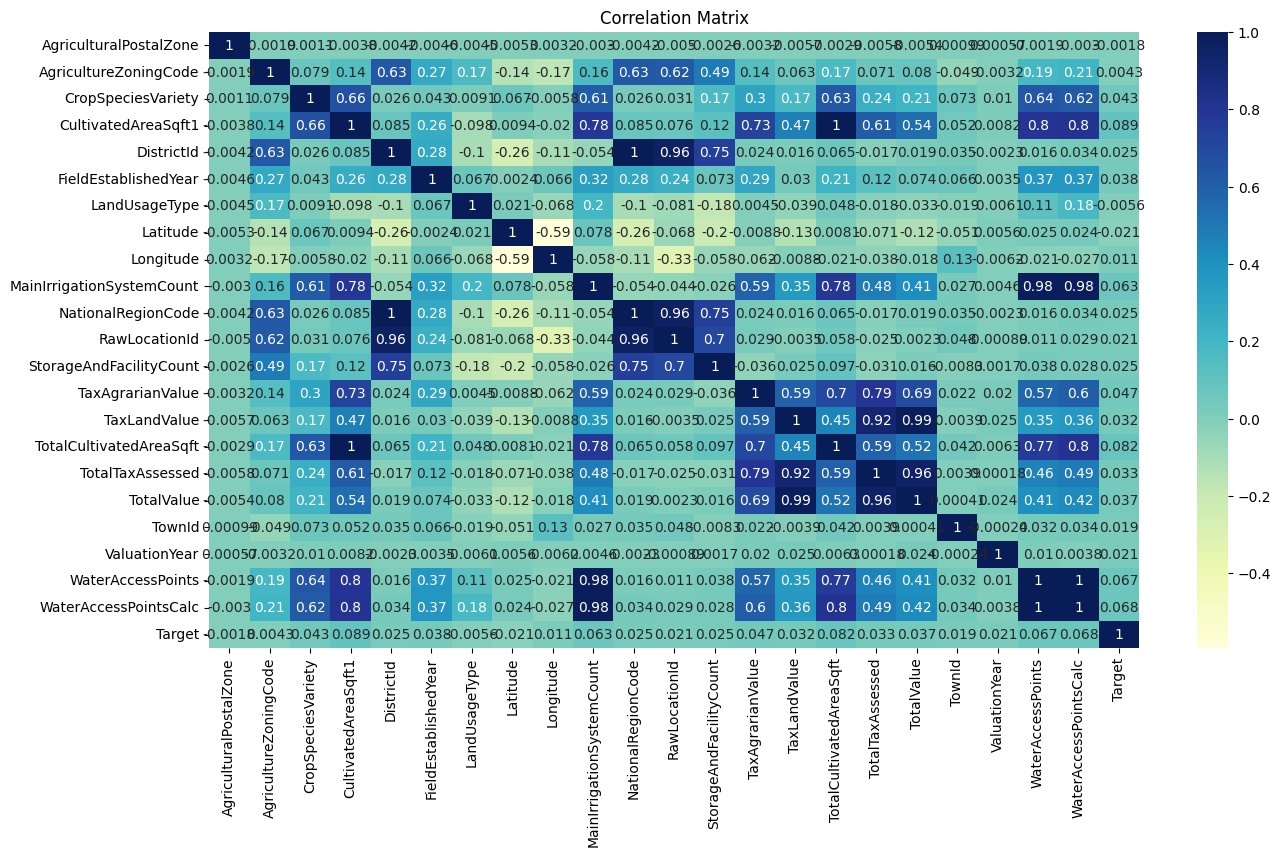

Target                       1.000000
CultivatedAreaSqft1          0.088554
TotalCultivatedAreaSqft      0.081660
WaterAccessPointsCalc        0.067908
WaterAccessPoints            0.067196
MainIrrigationSystemCount    0.063059
TaxAgrarianValue             0.047239
CropSpeciesVariety           0.042759
FieldEstablishedYear         0.037837
TotalValue                   0.037424
TotalTaxAssessed             0.033140
TaxLandValue                 0.032479
StorageAndFacilityCount      0.025295
NationalRegionCode           0.025267
DistrictId                   0.025267
Latitude                     0.021272
ValuationYear                0.020941
RawLocationId                0.020743
TownId                       0.019479
Longitude                    0.011231
LandUsageType                0.005639
AgricultureZoningCode        0.004302
AgriculturalPostalZone       0.001835
Name: Target, dtype: float64


In [14]:
corr = train_data.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.title("Correlation Matrix")
plt.show()

# Correlation with target variable
corr_target = abs(corr["Target"])
# sort the values in descending order
corr_target = corr_target.sort_values(ascending=False)
print(corr_target)

In [15]:
# drop columns with correlation less than 0.25296
columns_to_drop = corr_target[corr_target < 0.025296].index.tolist()

# Drop the identified columns from the DataFrame
train_data.drop(columns=columns_to_drop, axis=1, inplace=True)

test_data.drop(columns=columns_to_drop, axis=1, inplace=True)

# drop target column
train_data.drop(columns=['Target'], axis=1, inplace=True)

In [13]:
train_data = train_data.drop(columns=['TownId','Target','DistrictId'])

test_data = test_data.drop(columns=['TownId','DistrictId'])

In [13]:
def fill_missing_values(df):
    # Define the columns based on their type
    categorical_columns = [
        'HarvestProcessingType', 'SoilFertilityType', 'AgricultureZoningCode',
        'ValuationYear', 'NationalRegionCode', 'StorageAndFacilityCount', 'RawLocationId',
        'LandUsageType', 'CropSpeciesVariety', 'AgriculturalPostalZone'
    ]
    
    median_columns = [
        'FarmingUnitCount', 'FieldSizeSqft', 'CultivatedAreaSqft1', 'MainIrrigationSystemCount',
        'FieldEstablishedYear', 'TotalTaxAssessed', 'TaxLandValue', 'TotalCultivatedAreaSqft',
        'WaterAccessPoints', 'TaxAgrarianValue', 'TotalValue'
    ]
    
    mean_columns = [
        'WaterAccessPointsCalc', 'Longitude', 'Latitude'
    ]
    
    # Convert categorical columns to 'object' type if necessary
    # for column in categorical_columns:
    #     if column in df.columns:
    #         df[column] = df[column].astype('object')

    # Fill missing values for categorical columns using mode
    for column in categorical_columns:
        if column in df.columns:
            if df[column].isnull().sum() > 0:
                try:
                    mode_value = df[column].mode(dropna=True)[0] if not df[column].mode().empty else None
                    if mode_value is not None:
                        df[column].fillna(mode_value, inplace=True)
                    else:
                        print(f"Warning: Could not find a mode for column {column}")
                except Exception as e:
                    print(f"Error while filling mode for column {column}: {e}")
    
    # Fill missing values for numerical columns using median
    for column in median_columns:
        if column in df.columns and df[column].dtype in ['int64', 'float64']:
            if df[column].isnull().sum() > 0:
                median_value = df[column].median()
                df[column].fillna(median_value, inplace=True)
    
    # Fill missing values for numerical columns using mean
    for column in mean_columns:
        if column in df.columns and df[column].dtype in ['int64', 'float64']:
            if df[column].isnull().sum() > 0:
                mean_value = df[column].mean()
                df[column].fillna(mean_value, inplace=True)
    
    return df

# Fill missing values in the training data
train_data = fill_missing_values(train_data)

# Check if there are still missing values
missing_values = train_data.isnull().sum()
print("Missing values after filling:\n", missing_values[missing_values > 0])


Missing values after filling:
 Series([], dtype: int64)


/tmp/ipykernel_889841/871717399.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(mode_value, inplace=True)
/tmp/ipykernel_889841/871717399.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [16]:
# fill missing values in test data
test_data = fill_missing_values(test_data)

# Check if there are still missing values
missing_values = test_data.isnull().sum()

/tmp/ipykernel_889604/871717399.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(mode_value, inplace=True)
/tmp/ipykernel_889604/871717399.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [14]:
# use knn imupter to fill missing values
imputer = KNNImputer(n_neighbors=2)
train_data = pd.DataFrame(imputer.fit_transform(train_data), columns = train_data.columns, index=train_data.index)

In [16]:
train_data.head()

,AgriculturalPostalZone,AgricultureZoningCode,CropSpeciesVariety,CultivatedAreaSqft1,FieldEstablishedYear,LandUsageType,Latitude,Longitude,MainIrrigationSystemCount,NationalRegionCode,RawLocationId,StorageAndFacilityCount,TaxAgrarianValue,TaxLandValue,TotalCultivatedAreaSqft,TotalTaxAssessed,TotalValue,ValuationYear,WaterAccessPoints,WaterAccessPointsCalc
UID,,,,,,,,,,,,,,,,,,,,
12998,291674.0,0.0,3.0,1136.0,1926.0,1.0,2.466018e+07,7.850723e+07,2.0,1.0,4.010220e+07,0.0,81652.8,374602.8,1136.0,8636.716,456255.6,2018.0,2.0,2.0
20860,164397.0,28.0,4.0,2083.0,1981.0,1.0,2.436794e+07,7.911895e+07,3.0,1.0,4.010303e+07,0.0,323700.8,673186.8,2083.0,18464.292,996887.6,2018.0,3.0,3.0
75725,616532.0,0.0,2.0,922.0,1931.0,1.0,2.455721e+07,7.864265e+07,1.0,1.0,4.010210e+07,0.0,87440.0,956340.0,922.0,15594.568,1043780.0,2018.0,1.0,1.0
106521,942111.0,43.0,7.0,1431.5,1964.0,8.0,2.433931e+07,7.868407e+07,3.0,1.0,4.010139e+07,0.0,134075.2,301659.6,3202.0,8494.618,435734.8,2020.0,3.0,3.0
99467,475557.0,38.0,3.0,2225.0,2009.0,2.0,2.456592e+07,7.770447e+07,4.0,3.0,4.083903e+07,6.0,144000.0,741400.0,2225.0,13517.284,885400.0,2020.0,4.0,4.0


In [17]:
train_data.shape

(112569, 20)

In [18]:
test_data = pd.DataFrame(imputer.transform(test_data), columns = test_data.columns, index=test_data.index)

In [15]:
# convert Agriculturepostalzone to int
# train_data['AgriculturalPostalZone'] = train_data['AgriculturalPostalZone'].astype(float)
# test_data['AgriculturalPostalZone'] = test_data['AgriculturalPostalZone'].astype(float)

In [16]:
# sampling using smotenc
from imblearn.over_sampling import SMOTENC

cat_columns = ['AgricultureZoningCode', 'CropSpeciesVariety', 'LandUsageType', 'MainIrrigationSystemCount', 'NationalRegionCode', 'StorageAndFacilityCount', 'ValuationYear', 'WaterAccessPoints', 'RawLocationId', 'WaterAccessPointsCalc']

counter = collections.Counter(train_labels)
print(f"Before SMOTE: {counter}")
smotenc = SMOTENC(categorical_features=cat_columns, random_state=seed, sampling_strategy={0: 35000, 1: 67541, 2: 35000})

train_data, train_labels = smotenc.fit_resample(train_data, train_labels)
counter = collections.Counter(train_labels)
print(f"After SMOTE: {counter}")

Before SMOTE: Counter({1: 67541, 2: 22514, 0: 22514})
After SMOTE: Counter({1: 67541, 2: 35000, 0: 35000})


In [17]:
# sampling imbalance class with SMOTE 

# counter = collections.Counter(train_labels)
# print(f"Before SMOTE: {counter}")
# smote = SMOTE(sampling_strategy='auto', random_state=seed)

# train_data, train_labels = smote.fit_resample(train_data, train_labels)
# counter = collections.Counter(train_labels)
# print(f"After SMOTE: {counter}")


Before SMOTE: Counter({1: 67541, 2: 22514, 0: 22514})
After SMOTE: Counter({2: 67541, 1: 67541, 0: 67541})


In [31]:
train_data.head()

,AgriculturalPostalZone,AgricultureZoningCode,CropSpeciesVariety,CultivatedAreaSqft1,FieldEstablishedYear,LandUsageType,Latitude,Longitude,MainIrrigationSystemCount,NationalRegionCode,...,TaxAgrarianValue,TaxLandValue,TotalCultivatedAreaSqft,TotalTaxAssessed,TotalValue,ValuationYear,WaterAccessPoints,WaterAccessPointsCalc,UID,Target
0,-0.991318,-1.177963,-0.041439,-0.674586,-1.981477,-0.460164,1.056234,-0.645544,-0.261585,-0.675309,...,-0.378431,-0.265168,-0.689141,-0.288546,-0.298391,-0.924424,-0.296856,-0.328698,0,NaN
1,-1.480441,0.798664,0.832921,0.363848,0.343365,-0.460164,-0.046830,1.051641,0.780783,-0.675309,...,0.990884,0.037583,0.318328,0.331421,0.192807,-0.924424,0.707405,0.699971,1,medium
2,0.257108,-1.177963,-0.915799,-0.909248,-1.770128,-0.460164,0.667572,-0.269818,-1.303954,-0.675309,...,-0.345691,0.324686,-0.916806,0.150386,0.235412,-0.924424,-1.301116,-1.357368,2,medium
3,1.508304,1.857571,3.456002,-0.350555,-0.375222,4.985287,-0.154924,-0.154914,0.780783,-0.675309,...,-0.081866,-0.339129,1.508781,-0.297510,-0.317036,1.081813,0.707405,0.699971,3,medium
4,-0.284657,1.504602,-0.041439,0.519558,1.526922,0.317757,0.700425,-2.872759,1.823152,2.463403,...,-0.025720,0.106747,0.469396,0.019342,0.091514,1.081813,1.711665,1.728641,4,medium


In [29]:
# Standardize the features before training
scaler = StandardScaler()
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns, index=train_data.index)
test_data = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns, index=test_data.index)

In [30]:
# save preprocessed data
train_data['UID'] = train_data.index
train_data['Target'] = train_labels

# map target back to original values
target_mapping = {0: 'low', 1: 'medium', 2: 'high'}
train_data['Target'] = train_data['Target'].map(target_mapping)

train_data.to_csv("../data/preprocessed_train_KNNim.csv", index=False)

test_data['UID'] = test_data.index
test_data.to_csv("../data/preprocessed_test_KNNim.csv", index=False)